In [291]:
#Import necessary libraries 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mpl3d
from matplotlib import animation, rc
from astropy import constants as constants
from astropy import units as units
from IPython.display import HTML
import seaborn as sns

In [292]:
sns.set_style("darkgrid")

Units:

- Mass in Solar masses $M_{\odot}$
- Distance in Astronomical Units (au)
- Time in years (yr)
- Gravitational Constant $G = 4\pi^2$


In [293]:
# global constants
ggrav = 6.67e-8
msun  = 1.99e33
seconds_per_year = 24.*3600*365 # roughly
cm_per_pc = 3.1e18

In [294]:
#Constants 
G = 4*np.pi**2
#M_sun = constants.M_sun.value #in Kg
M_sun = 1.98855e30
Au_in_meters = 1.49598261e11
#Au_in_meters = (1*units.AU).to(units.m).value
#Year_in_seconds = (1*units.yr).to(units.s).value
Year_in_seconds = 3600*24*365


## Equations of motion of N-bodies

The equations of motion of N-bodies moving under their mutual gravitational interaction are given by $N$-vector differential equations of second order

$\begin{equation}
m_i \ddot{\vec{x}}_i = - G m_i \sum_{j=1,i\ne j}^N \frac{m_j}{|\vec{x}_{ij}|^3} \vec{x}_{ij},
\end{equation}$

where $\vec{x}_{ij} = \vec{x}_i - \vec{x}_j$ is the vector pointing from the particle $j$ to the the particle $i$. 

We can write this differential system as a set of $2N$-vector differential equations of first order,

$\begin{align}
\begin{cases}
\frac{d \vec{x}_i}{dt} = &\vec{v}_i \\
\frac{d\vec{v}_i}{dt} = &- G \sum_{j=1,i\ne j}^N \frac{m_j}{|\vec{x}_{ij}|^3} \vec{x}_{ij}.
\end{cases}
\end{align}$

These vector equations are written in terms of the cartesian components of the position $\vec{x} = (x,y,z)$ and the velocity $\vec{v} = (v^x, v^y, v^z)$ as the set

$\begin{align}
\begin{cases}
\frac{d x_i}{dt} = &v^x_i \\
\frac{d y_i}{dt} = &v^y_i \\
\frac{d z_i}{dt} = &v^z_i \\
\frac{dv^x_i}{dt} = &- G \sum_{j=1,i\ne j}^N \frac{m_j (x_i - x_j)}{r_{ij}^3} \\
\frac{dv^y_i}{dt} = &- G \sum_{j=1,i\ne j}^N \frac{m_j (y_i - y_j)}{r_{ij}^3} \\
\frac{dv^z_i}{dt} = &- G \sum_{j=1,i\ne j}^N \frac{m_j (z_i - z_j)}{r_{ij}^3} 
\end{cases}
\end{align}$

where $|\vec{x}_{ij}| = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2+ (z_i - z_j)^2} = r_{ij}$.

In [295]:
def NbodyEq(u,mass,time):
    x_old = u[:,0]
    y_old = u[:,1]
    z_old = u[:,2]
    
    n = len(x_old)
    
    vx_old = u[:,3]
    vy_old = u[:,4]
    vz_old = u[:,5]
    vx_new = np.zeros(n)
    vy_new = np.zeros(n)
    vz_new = np.zeros(n)
    
    
    dx = vx_old
    dy = vy_old
    dz = vz_old
    
    for i in range(len(x_old)):
        xtemp = np.delete(x_old,i)
        ytemp = np.delete(y_old,i)
        ztemp = np.delete(z_old,i)
        masstemp = np.delete(mass,i)
        
        vec_x = x_old[i]-xtemp
        vec_y = y_old[i]-ytemp
        vec_z = z_old[i]-ztemp
        
        length = (vec_x**2+vec_y**2+vec_z**2)**(0.5)
        
        ax = -ggrav*masstemp*vec_x/length**3
        ay = -ggrav*masstemp*vec_y/length**3
        az = -ggrav*masstemp*vec_z/length**3
        
        vx_new[i] = np.sum(ax)
        vy_new[i] = np.sum(ay)
        vz_new[i] = np.sum(az)
    
    q1 = np.zeros(np.shape(u))
    q1[:,0] = dx
    q1[:,1] = dy
    q1[:,2] = dz
    q1[:,3] = vx_new
    q1[:,4] = vy_new
    q1[:,5] = vz_new
    return q1






## RK4 Method

$\begin{align}
k_1 &= hf(x_n,y_n) \\
k_2 &=h f(x_n + \frac{h}{2},y_n + \frac{1}{2}k_1) \\
k_3 &=h f(x_n + \frac{h}{2},y_n + \frac{1}{2}k_2) \\
k_4 &=h f(x_n+h,y_n + k_3) \\
y_{n+1} &= y_n + \frac{1}{6}(k_1 + 2 k_2 + 2 k_3 + k_4) + \mathcal{O}(h^5)
\end{align}$




In [296]:
def NbodyRK4(u,mass,time,dt):
    k1 = dt*NbodyEq(u, mass, time)
    k2 = dt*NbodyEq(u+0.5*k1, mass, time+0.5*dt)
    k3 = dt*NbodyEq(u+0.5*k2, mass, time+0.5*dt)
    k4 = dt*NbodyEq(u+k3, mass, time+dt)
    
    q1 = u + (1./6)*(k1+2.*k2+2.*k3+k4)
    
    return q1

## Conserved Energy

$\begin{equation}
E = \frac{1}{2} \sum_{i=1}^N m_i |\vec{v}_i|^2 -
 G \sum_{i=1}^N \sum_{j=1,i\ne j}^N \frac{m_i m_j}{r_{ij}}
\end{equation}$

In [297]:
def TotalEnergy(u,mass,time):
    x_old = u[:,0]
    y_old = u[:,1]
    z_old = u[:,2]
    vx_old = u[:,3]
    vy_old = u[:,4]
    vz_old = u[:,5]
    
    n = len(x_old)
    
    E_k = np.sum(0.5*mass*(vx_old**2+vy_old**2+vz_old**2))
    
    E_pot = 0.
    for i in range(n):
        xtemp = np.delete(x_old,i)
        ytemp = np.delete(y_old,i)
        ztemp = np.delete(z_old,i)
        masstemp = np.delete(mass,i)
        
        vec_x = x_old[i]-xtemp
        vec_y = y_old[i]-ytemp
        vec_z = z_old[i]-ztemp
        
        length = (vec_x**2+vec_y**2+vec_z**2)**(0.5)
        
        E_pot += np.sum(-ggrav*mass[i]*masstemp/length)
    
    return E_pot + E_k

## Evaluation of Sun - Earth System for 2 years

In [298]:
#Distance is in m, mass is in Kg
initial_data_file = 'sun_earth.asc'

(x,y,z,vx,vy,vz,mass) = np.loadtxt(initial_data_file, unpack = True)

distance_unit_to_cm = 1.
time_unit_to_s = 1.
mass_unit_to_g = 1.
Nsteps = int(1e4)
t0 = 0
t1 = 2 * seconds_per_year
dt = (t1-t0)/Nsteps
time_grid = np.linspace(t0,t1,Nsteps)

x *= distance_unit_to_cm
y *= distance_unit_to_cm
z *= distance_unit_to_cm
vx *= distance_unit_to_cm / time_unit_to_s
vy *= distance_unit_to_cm / time_unit_to_s
vz *= distance_unit_to_cm / time_unit_to_s
mass *= mass_unit_to_g

u = np.array((x,y,z,vx,vy,vz)).transpose()
Nbodies = len(x)


In [299]:
f = np.zeros([int(Nsteps),int(Nbodies),6])
f[0] = u

E = np.zeros(Nsteps)
E[0] = TotalEnergy(f[0],mass,0)

for i in range(int(Nsteps)-1):
    t = t0 + i*dt
    f[i+1] = NbodyRK4(f[i],mass,t,dt)
    E[i+1] = TotalEnergy(f[i],mass,t)

In [300]:
boundary = 2e13
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-boundary, boundary)
ax.set_ylim3d(-boundary, boundary)
ax.set_zlim3d(-boundary, boundary)
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.grid(False)
ax._axis3don = False
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
plt.close()
def animate(i):
    ax.clear()
    ax.scatter(f[:,0,0],f[:,0,1],f[:,0,2],edgecolors='dodgerblue',facecolors='lightskyblue',s=20)
    ax.set_xlim3d(-boundary, boundary)
    ax.set_ylim3d(-boundary, boundary)
    ax.set_zlim3d(-boundary, boundary)
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.grid(False)
    ax._axis3don = False
    ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    points = np.linspace(0,Nsteps-1,201)
    
    a = int(points[i])  
    t = time_grid[a] / seconds_per_year
    title = 'Time elpased:' + str('%.2f' %t) + ' years'
    title
    ax.set_title(title,color='white')
    for j in range(Nbodies-1):
        ax.plot(f[:,j+1,0][0:a],f[:,j+1,1][0:a],f[:,j+1,2][0:a],c='turquoise')
        ax.scatter(f[:,j+1,0][a],f[:,j+1,1][a],f[:,j+1,2][a],edgecolors='dodgerblue',facecolors='lightskyblue',s=20)
    return fig,

anim = animation.FuncAnimation(fig, animate,frames=200, interval=60)

In [301]:
anim.save('sun_earth.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


In [302]:
HTML(anim.to_jshtml())

## Total System Energy

Text(0, 0.5, 'Total Energy')

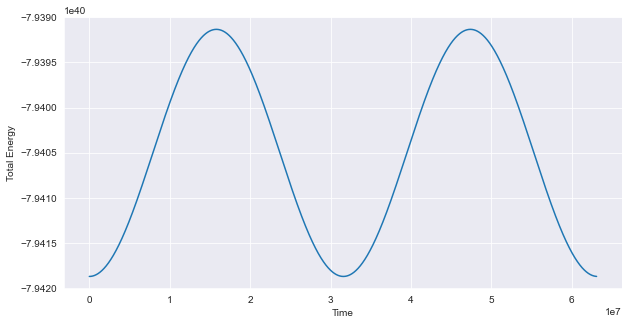

In [303]:
fig = plt.figure(figsize = (10,5))
sns.lineplot(y=E,x=time_grid)
plt.xlabel('Time')
plt.ylabel('Total Energy')



## Total System Energy with step variation

Text(0, 0.5, 'Total Energy')

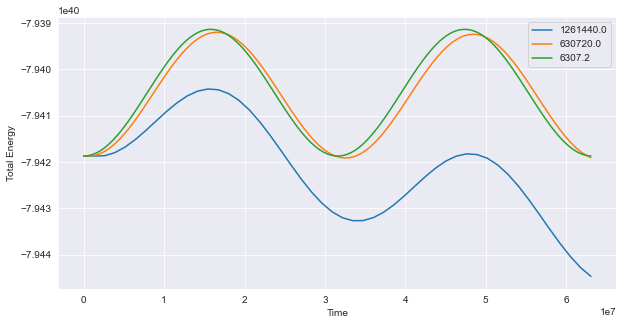

In [304]:
fig = plt.figure(figsize = (10,5))
for i in [0.5e2,1e2,1e4]:
    Nsteps = int(i)
    t0 = 0
    t1 = 2 * seconds_per_year
    dt = (t1-t0)/Nsteps
    time_grid = np.linspace(t0,t1,Nsteps)
    f = np.zeros([int(Nsteps),int(Nbodies),6])
    f[0] = u

    E = np.zeros(Nsteps)
    E[0] = TotalEnergy(f[0],mass,0)

    for j in range(int(Nsteps)-1):
        t = t0 + i*dt
        f[j+1] = NbodyRK4(f[j],mass,t,dt)
        E[j+1] = TotalEnergy(f[j],mass,t)
    label = 'dt: '+str(dt)
    sns.lineplot(y=E,x=time_grid,label=dt)
plt.xlabel('Time')
plt.ylabel('Total Energy')

## Evaluation of N-body SgrA* System for 100 Years

In [305]:
distance_unit_to_cm = 0.04*cm_per_pc
time_unit_to_s = seconds_per_year
mass_unit_to_g = msun
Nsteps = int(2e4)
t0 = 0
t1 = 100 * seconds_per_year
dt = (t1-t0)/Nsteps

initial_data_file = 'sgrAstar.asc'
(x,y,z,vx,vy,vz,mass) = np.loadtxt(initial_data_file, unpack = True)

# convert from unitis in initial data file to cgs
x *= distance_unit_to_cm
y *= distance_unit_to_cm
z *= distance_unit_to_cm
vx *= distance_unit_to_cm / time_unit_to_s
vy *= distance_unit_to_cm / time_unit_to_s
vz *= distance_unit_to_cm / time_unit_to_s
mass *= mass_unit_to_g

Nbodies = len(x)
time_grid = np.linspace(t0,t1,Nsteps)

u = np.array((x,y,z,vx,vy,vz)).transpose()


In [306]:
f = np.zeros([int(Nsteps),int(Nbodies),6])
f[0] = u

for i in range(int(Nsteps)-1):
    t = t0 + i*dt
    f[i+1] = NbodyRK4(f[i],mass,t,dt)

In [307]:
boundary = max(abs(np.amax(f[:,:,0:3])), abs(np.amin(f[:,:,0:3])))*(1+0.1)
boundary

2.4122166531357277e+17

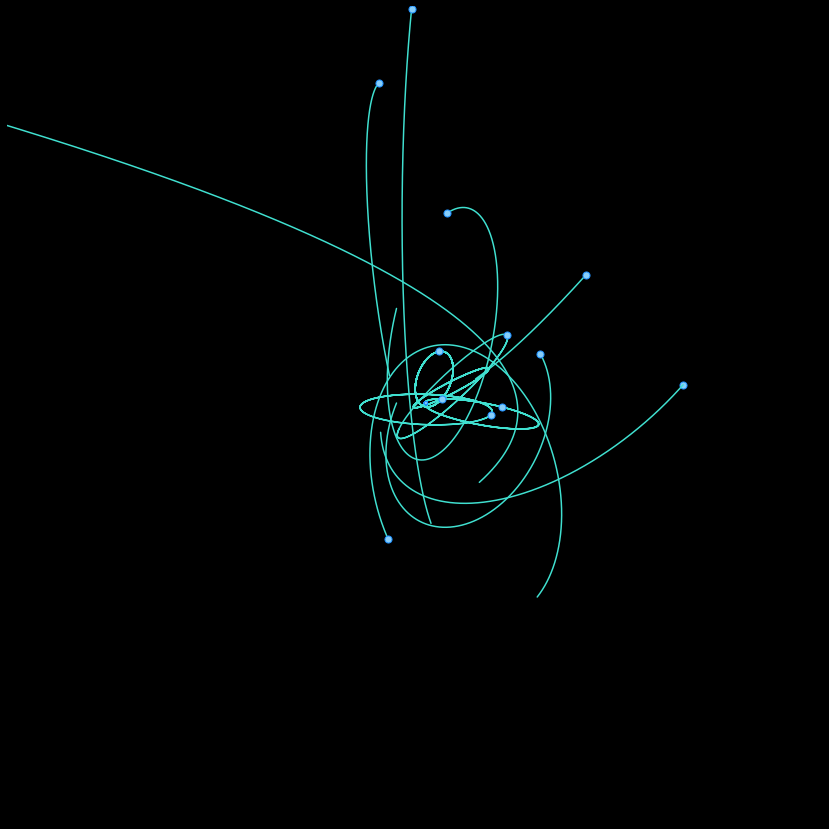

In [308]:
boundary = 1e17 #Modified graph boundries
points = np.linspace(0,Nsteps-1,201)
i = int(points[200])
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(f[:,0,0],f[:,0,1],f[:,0,2],edgecolors='dodgerblue',facecolors='lightskyblue',s=10)
ax.set_xlim3d(-boundary, boundary)
ax.set_ylim3d(-boundary, boundary)
ax.set_zlim3d(-boundary, boundary)
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.grid(False)
ax._axis3don = False
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
for j in range(Nbodies-1):
    ax.plot(f[:,j+1,0][0:i],f[:,j+1,1][0:i],f[:,j+1,2][0:i],c='turquoise')
    ax.scatter(f[:,j+1,0][i],f[:,j+1,1][i],f[:,j+1,2][i],edgecolors='dodgerblue',facecolors='lightskyblue',s=50)

In [309]:
boundary = 1e17
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-boundary, boundary)
ax.set_ylim3d(-boundary, boundary)
ax.set_zlim3d(-boundary, boundary)
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.grid(False)
ax._axis3don = False
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
plt.close()
def animate(i):
    ax.clear()
    ax.scatter(f[:,0,0],f[:,0,1],f[:,0,2],edgecolors='dodgerblue',facecolors='lightskyblue',s=20)
    ax.set_xlim3d(-boundary, boundary)
    ax.set_ylim3d(-boundary, boundary)
    ax.set_zlim3d(-boundary, boundary)
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.grid(False)
    ax._axis3don = False
    ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    points = np.linspace(0,Nsteps-1,1001)
    
    a = int(points[i])  
    t = time_grid[a] / seconds_per_year
    title = 'Time elpased:' + str('%.2f' %t) + ' years'
    title
    ax.set_title(title,color='white')
    for j in range(Nbodies-1):
        ax.plot(f[:,j+1,0][0:a],f[:,j+1,1][0:a],f[:,j+1,2][0:a],c='turquoise')
        ax.scatter(f[:,j+1,0][a],f[:,j+1,1][a],f[:,j+1,2][a],edgecolors='dodgerblue',facecolors='lightskyblue',s=20)
    return fig,

anim = animation.FuncAnimation(fig, animate,frames=1000, interval=20)

In [310]:
anim.save('sgrAstar100years.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


<center><img src="sgrAstar100years.gif" alt="100years" width="500"></center>

## Evaluation of N-body SgrA* System for 500 years

In [311]:
distance_unit_to_cm = 0.04*cm_per_pc
time_unit_to_s = seconds_per_year
mass_unit_to_g = msun
Nsteps = int(1e5)
t0 = 0
t1 = 500 * seconds_per_year
dt = (t1-t0)/Nsteps

initial_data_file = 'sgrAstar.asc'
(x,y,z,vx,vy,vz,mass) = np.loadtxt(initial_data_file, unpack = True)

# convert from unitis in initial data file to cgs
x *= distance_unit_to_cm
y *= distance_unit_to_cm
z *= distance_unit_to_cm
vx *= distance_unit_to_cm / time_unit_to_s
vy *= distance_unit_to_cm / time_unit_to_s
vz *= distance_unit_to_cm / time_unit_to_s
mass *= mass_unit_to_g

Nbodies = len(x)
time_grid = np.linspace(t0,t1,Nsteps)

u = np.array((x,y,z,vx,vy,vz)).transpose()

f = np.zeros([int(Nsteps),int(Nbodies),6])
f[0] = u

for i in range(int(Nsteps)-1):
    t = t0 + i*dt
    f[i+1] = NbodyRK4(f[i],mass,t,dt)



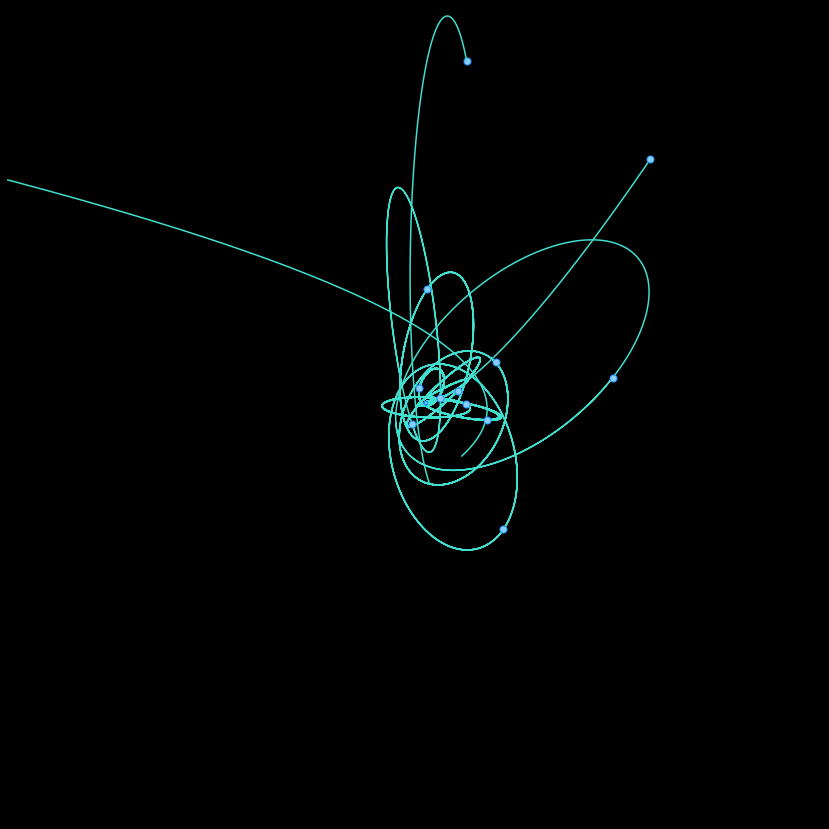

In [312]:
boundary = 1.5e17
points = np.linspace(0,Nsteps-1,201)
i = int(points[200])
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(f[:,0,0],f[:,0,1],f[:,0,2],edgecolors='dodgerblue',facecolors='lightskyblue',s=10)
ax.set_xlim3d(-boundary, boundary)
ax.set_ylim3d(-boundary, boundary)
ax.set_zlim3d(-boundary, boundary)
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.grid(False)
ax._axis3don = False
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
for j in range(Nbodies-1):
    ax.plot(f[:,j+1,0][0:i],f[:,j+1,1][0:i],f[:,j+1,2][0:i],c='turquoise')
    ax.scatter(f[:,j+1,0][i],f[:,j+1,1][i],f[:,j+1,2][i],edgecolors='dodgerblue',facecolors='lightskyblue',s=50)



In [313]:
boundary = 1.5e17
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-boundary, boundary)
ax.set_ylim3d(-boundary, boundary)
ax.set_zlim3d(-boundary, boundary)
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.grid(False)
ax._axis3don = False
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
plt.close()
def animate(i):
    ax.clear()
    ax.scatter(f[:,0,0],f[:,0,1],f[:,0,2],edgecolors='dodgerblue',facecolors='lightskyblue',s=20)
    ax.set_xlim3d(-boundary, boundary)
    ax.set_ylim3d(-boundary, boundary)
    ax.set_zlim3d(-boundary, boundary)
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.grid(False)
    ax._axis3don = False
    ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    points = np.linspace(0,Nsteps-1,1001)
    
    a = int(points[i])  
    t = time_grid[a] / seconds_per_year
    title = 'Time elpased:' + str('%.2f' %t) + ' years'
    title
    ax.set_title(title,color='white')
    for j in range(Nbodies-1):
        ax.plot(f[:,j+1,0][0:a],f[:,j+1,1][0:a],f[:,j+1,2][0:a],c='turquoise')
        ax.scatter(f[:,j+1,0][a],f[:,j+1,1][a],f[:,j+1,2][a],edgecolors='dodgerblue',facecolors='lightskyblue',s=20)
    return fig,

anim = animation.FuncAnimation(fig, animate,frames=1000, interval=20)
anim.save('sgrAstar500years.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


<center><img src="sgrAstar500years.gif" alt="500years" width="500"></center>

## Total System Energy with step variation

Text(0, 0.5, 'Total Energy')

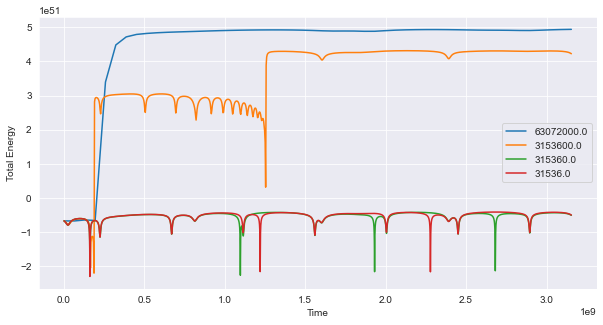

In [314]:
fig = plt.figure(figsize = (10,5))
for i in [0.5e2,1e3,1e4,1e5]:
    Nsteps = int(i)
    t0 = 0
    t1 = 100 * seconds_per_year
    dt = (t1-t0)/Nsteps
    time_grid = np.linspace(t0,t1,Nsteps)
    f = np.zeros([int(Nsteps),int(Nbodies),6])
    f[0] = u

    E = np.zeros(Nsteps)
    E[0] = TotalEnergy(f[0],mass,0)

    for j in range(int(Nsteps)-1):
        t = t0 + i*dt
        f[j+1] = NbodyRK4(f[j],mass,t,dt)
        E[j+1] = TotalEnergy(f[j],mass,t)
    label = 'dt: '+str(dt)
    sns.lineplot(y=E,x=time_grid,label=dt)
plt.xlabel('Time')
plt.ylabel('Total Energy')